### Assumptions

Linear models require the following assumptions to hold true:

1. Linearity  
The response variable is a linear combination of the predictors
$y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_p x_p + \varepsilon$

2. Independence of Observations  
The observations $(x_i, y_i)$ are independent and identically distributed

3. Error Properties  
The error terms $\varepsilon_i$ are independent and identically (iid) normally distributed with mean 0 and constant variance $N(0, \sigma^2)$

4. No Perfect Multicollinearity  
The predictors are not perfectly linearly dependent. That is, no predictor is a perfect linear combination of the others

Note that the error term having constant variance is refered to as homoskedasticity with the converse is refered to as heteroskedasticity. 

### Linearity

If the response is not a linear combination of the parameters, the coefficients may be biased and predictions can be unreliabel. There are two main ways to test for linearity:
1. Residuals vs Fitted Values Plot
    - This should look like random noise around 0 (i.e. normally distributed)
    - A U-shape or S-shape may be evidence of non-linearity
2. Ramsey RESET Test
    - Adds squared/cubic terms of fitted values to the model
    - Null hypothesis: Model is correctly specified (linear)
    - Alternative hypothesis: Non-linearity present.

If non-linearity is present you can try to take transformations of the predictors (e.g. log, polynomial etc). If non-linearity is still present, you may consider moving to a different model that can handle non-linearity (e.g. XGBoost)

In the example below, we first generate a data which is not a linear combination of the predictors. We fit a deliberately mis-specified linear model and plot the residuals vs fitted values. We observe a clear quadratic shape rather than symmetric noise around 0 and therefore conclude the presence of non-linearity. Next we fit a correctly specified model and again plot the residuals vs fitted values. We do not detect non-linearity due to the symmetreic noise around 0.  

Additionally, we perform two Ramsey RESET hypothesis tests to detect non-linearity in each of the two models. As expected, we detect non-linearity (p < 0.05) in the misspecified model and fail to detect it in the correctly specified model. 

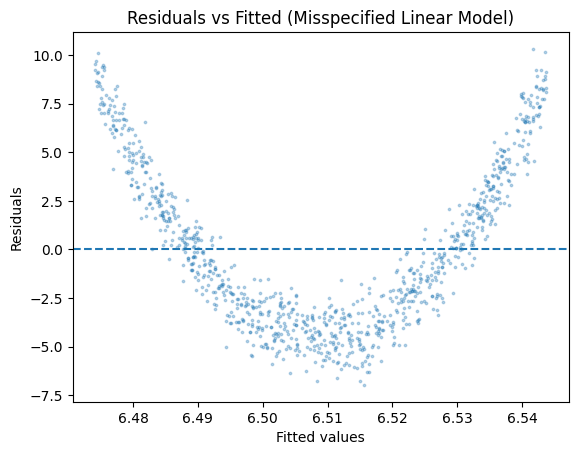

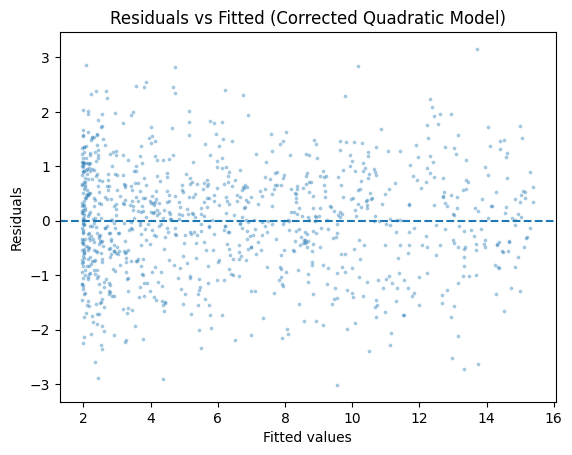

RESET test (bad model):
Chi2-stat: 15322.28027394268
p-value: 0.0
We reject the Null hypothesis (at the 5% significance level) that the model was correctly specified. That is, we detect non-linearity

RESET test (corrected model):
Chi2-stat: 0.4327031024670872
p-value: 0.5106655492104478
We do not reject the Null hypothesis (at the 5% significance level) that the model was correctly specified. That is, we do not detect non-linearity


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import linear_reset

# 1. Generate data (true quadratic relationship)
rng = np.random.default_rng(42)
n = 1000
x = rng.uniform(-3, 3, n)
eps = rng.normal(0, 1, n)
y = 2 + 1.5 * x**2 + eps   # quadratic in x

df = pd.DataFrame({"y": y, "x": x})

# 2. Misspecified linear model (i.e. non-linearity present)
model_bad = smf.ols("y ~ x", data=df).fit()
df["resid_bad"] = model_bad.resid
df["fitted_bad"] = model_bad.fittedvalues

plt.scatter(df["fitted_bad"], df["resid_bad"], alpha=0.3, s=3)
plt.axhline(0, ls="--")
plt.title("Residuals vs Fitted (Misspecified Linear Model)")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.show()

# 3. Corrected model with quadratic term
df["x2"] = df["x"]**2
model_fix = smf.ols("y ~ x + x2", data=df).fit()
df["resid_fix"] = model_fix.resid
df["fitted_fix"] = model_fix.fittedvalues

plt.scatter(df["fitted_fix"], df["resid_fix"], alpha=0.3, s=3)
plt.axhline(0, ls="--")
plt.title("Residuals vs Fitted (Corrected Quadratic Model)")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.show()

# 4. Ramsey RESET test to detect non-linearity

# For the misspecified model
reset_bad = linear_reset(model_bad, power=2, test_type='fitted')
print("RESET test (bad model):")
print("Chi2-stat:", reset_bad.statistic)
print("p-value:", reset_bad.pvalue)
print("We reject the Null hypothesis (at the 5% significance level) that the model was correctly specified. That is, we detect non-linearity")

# For the corrected model
reset_fix = linear_reset(model_fix, power=2, test_type="fitted")
print("\nRESET test (corrected model):")
print("Chi2-stat:", reset_fix.statistic)
print("p-value:", reset_fix.pvalue)
print("We do not reject the Null hypothesis (at the 5% significance level) that the model was correctly specified. That is, we do not detect non-linearity")

### Independence of Observations
This assumption cannot be tested statistically and is more of an assumption about the underlying phenomenon you are observing and the data collection process. Generally, if random sampling is used, independence of observations is a reasonable assumption. However, if the same process is measured over time (e.g. temperature of a room) then this assumption is unlikely to hold. In the case of dependent observations, the estimated coefficients may still be unbiased however the standard errors will be wrong This can lead to invalid hypothesis tests and confidence intervals. 

Often time-series datasets break this assumption since the observations are usually time dependent. That is, the value now is related to the value in the past. In the example of time series, you can use autoregressive models such as ARIMA instead. 

### Independence of Errors
If independence of errors is violated the coefficient estimates are still unbiased, but standard errors are wrong and consequently predictions are unreliable. This is checked by examining the residuals. 

We use the Durbin-Watson hypothesis test to detect autocorrelation in residuals. The statistic ranges from 0-4 and is interpretted as follows:
- ≈2 no autocorrelation
- <2 positive correlation
- \>2 negative correlation

In the example below we first generate a dataset where the error values are directly computed from the previous values (thus introducing dependence). We fit a simple linear model and compute the residuals. Then we perform the Durbin-Watson hypothesis test on each set of residuals and detect to detect autocorrelation of the residuals. Next we generate an independent dataset, fit a simply linear model and compute the residuals. This time, the Durbin-Watson hypothesis test fails to detect autocorrelation of the residuals. 

In [2]:
from statsmodels.stats.stattools import durbin_watson

# 1. Generate autocorrelated data (i.e. values depend on previous values)
n = 1000
x = range(n)
eps = rng.normal(0, 1, n)
rho = 0.8  # autocorrelation strength
for i in range(n):
    if i == 0:
        eps[i] = rng.normal(0, 1)
    else:
        eps[i] = rho * eps[i-1] + rng.normal(0, 1)

y = 10 + 3 * np.arange(n) + eps

autocorrelated_df = pd.DataFrame({"y": y, "x": x})

# 2. Fit linear model
autocorrelated_model = smf.ols("y ~ x", data=autocorrelated_df).fit()
autocorrelated_df["resid_"] = autocorrelated_model.resid
autocorrelated_df["fitted_"] = autocorrelated_model.fittedvalues

# 3. Compute Durbin-Watson statistic
autocorrelated_dw = durbin_watson(autocorrelated_model.resid)
print("Durbin-Watson:", autocorrelated_dw)
print("Durbin-Watson hypothesis tests detects positive autocorrelation")

# 4. Generate independent data
n = 1000
x = range(n)
eps = rng.normal(0, 1, n)
y = []
for i in x:
    #  No dependency of residuals
    y.append(10 + 2 * x[i] + eps[i])

df = pd.DataFrame({"y": y, "x": x})

# 5. Fit linear model
model = smf.ols("y ~ x", data=df).fit()
df["resid_"] = model.resid
df["fitted_"] = model.fittedvalues

# 6. Compute Durbin-Watson statistic
dw = durbin_watson(model.resid)
print("Durbin-Watson:", dw)
print("Durbin-Watson hypothesis tests fails to detect autocorrelation")


Durbin-Watson: 0.3866729795485667
Durbin-Watson hypothesis tests detects positive autocorrelation
Durbin-Watson: 1.9834896405663813
Durbin-Watson hypothesis tests fails to detect autocorrelation


### Normal Errors
If the errors are not normally distributed with mean 0 and constant variance $N(0, \sigma^2)$ the coefficient estimates are still unbiased, but standard errors are wrong and consequently predictions are unreliable. We can check this in the following two ways:
1. Quantile-Quantile (QQ) plot
    - Plots the quantiles of the residuals (scaled to $N(0, 1)$) against the quantiles of a stanadrd normal distribution $N(0, 1)$
    - If the residuals are normally distribured, the points of the qq plot should lie of a straight line with gradient 1
    - If there are large deviations from this straight line, it suggests the residuals are not normal
2. Shapiro-Wilk Hypothesis Test
    - Null hypothesis: Errors are drawn from a normal distribution
    - Alternative: Errors are not drawn from a normal distribution

In the example below we first generate a dataset where the error values are not from a normal distribution and then a dataset where the errors are normal. We fit a simple linear model to each, compute the residuals and then create the QQ plots. In the first case we see the points of the QQ plot deviate far from the straight line thus suggesting the errors are not $N(0, \sigma^2)$. In the second QQ plot the points roughly follow the straight line thus suggesting the errors are $N(0, \sigma^2)$. We also annotate the QQ plots with the Shapiro-Wilk p-value. These tests provide further evidence in line with the QQ plots regarding the normality of teh residuals. 

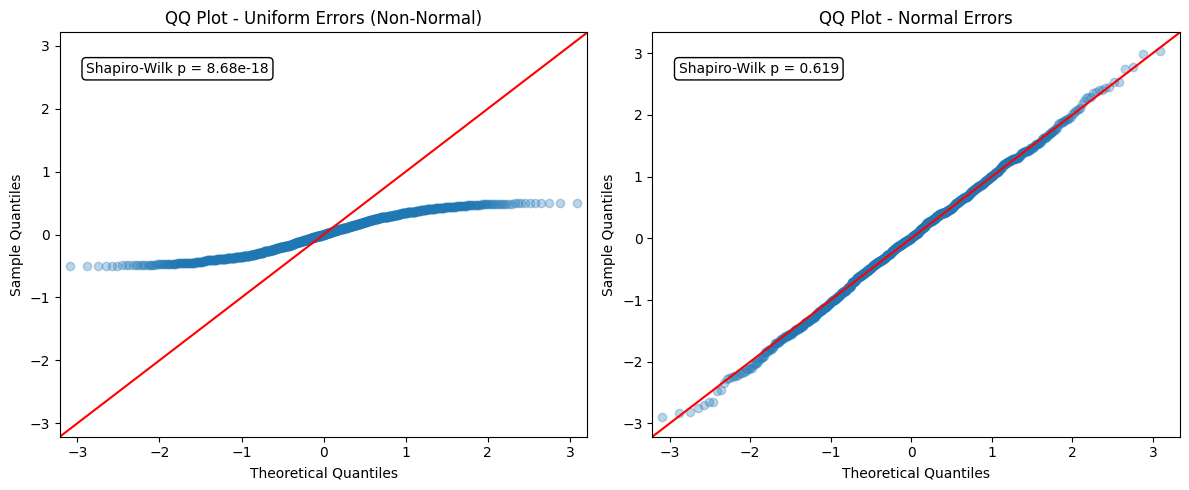

In [5]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from scipy.stats import shapiro

rng = np.random.default_rng(42)

# 1. Generate dataset with non-normal residuals (Uniform errors)
n = 1000
x = np.arange(n)
error_non_normal = rng.uniform(0, 1, n)
y_non_normal = 5 + 8 * x + error_non_normal
df_non_normal = pd.DataFrame({"y": y_non_normal, "x": x})

# 2. Generate dataset with normal residuals (Normal errors)
error_normal = rng.normal(0, 1, n)
y_normal = 5 + 8 * x + error_normal
df_normal = pd.DataFrame({"y": y_normal, "x": x})

# 3. Fit models and compute residuals
model_non_normal = smf.ols("y ~ x", data=df_non_normal).fit()
df_non_normal["resid_"] = model_non_normal.resid

model_normal = smf.ols("y ~ x", data=df_normal).fit()
df_normal["resid_"] = model_normal.resid

# 4. Compute Shapiro-Wilk test results
stat_non_norm, p_non_norm = shapiro(df_non_normal["resid_"])
stat_norm, p_norm = shapiro(df_normal["resid_"])

# 5. Create QQ plots with annotations
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sm.qqplot(df_non_normal["resid_"], line="45", ax=axes[0], alpha=0.3)
axes[0].set_title("QQ Plot - Uniform Errors (Non-Normal)")
axes[0].annotate(f"Shapiro-Wilk p = {p_non_norm:.3g}", xy=(0.05, 0.9), 
                 xycoords="axes fraction", fontsize=10, 
                 bbox=dict(boxstyle="round", fc="w"))

sm.qqplot(df_normal["resid_"], line="45", ax=axes[1], alpha=0.3)
axes[1].set_title("QQ Plot - Normal Errors")
axes[1].annotate(f"Shapiro-Wilk p = {p_norm:.3g}", xy=(0.05, 0.9), 
                 xycoords="axes fraction", fontsize=10, 
                 bbox=dict(boxstyle="round", fc="w"))

plt.tight_layout()
plt.show()


### No Perfect Multicolinearity
If perfect multicollinearity exists (e.g. including both “Age in years” and “Age in months”), the model cannot uniquely estimate regression coefficients. That makes the design matrix $X$ singular $\rightarrow$ its determinant is $0$, and it cannot be inverted. Since OLS coefficient estimation relies on $(X'X)^{-1}$, the model cannot be estimated uniquely.

In practice, it is also important to check for high (but not perfect) multicollinearity, where predictors are strongly correlated. While the model can still be estimated, high multicollinearity inflates the standard errors of the coefficients, making inference unreliable. A common way to assess this is by computing the **Variance Inflation Factor (VIF)** for each predictor. For a given predictor $X_j$, the Variance Inflation Factor is:

$\mathrm{VIF}_j = \frac{1}{1 - R_j^2}$

where $R_j^2$ is the coefficient of determination from regressing $X_j$ on all the other predictors in the model.

If $X_j$ is uncorrelated with the other predictors, then $R_j^2 \approx 0$, so:

$\mathrm{VIF}_j \approx 1$

→ No inflation of variance.

If $X_j$ is highly correlated with the other predictors, then $R_j^2$ is close to 1, so:

$\mathrm{VIF}_j \gg 1$

→ The variance of $\hat{\beta}_j$ is much larger than it would be without collinearity.

So VIF tells you how much the variance of a coefficient is “inflated” due to collinearity.

The example below shows two data sets, one with perfect multicollinearity and one without. In each case we compute the VIF for each predictor and demonstrate that in the first case, we have perfect multicollinearity. Note that the model summary says "The smallest eigenvalue is x. This might indicate that there are strong multicollinearity problems or that the design matrix is singular." In reality this value is 0 and the small difference stated is due to numeric methods (i.e. computers can't compute it exactly). 


In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1. Generate data with perfect multicollinearity
n = 1000
x1 = range(n)
x2 = 4 * np.arange(n)
eps = rng.normal(0, 1, n)
y = 10 + 2 * np.arange(n) + 4 * np.arange(n) + eps

perfect_mcl_df = pd.DataFrame({"y": y, "x1": x1, "x2": x2})

# 2. Generate data without perfect multicollinearity
n = 1000
x1 = rng.normal(0, 1, n)
x2 = rng.normal(0, 1, n)
eps = rng.normal(0, 1, n)
y = 10 + 2 * np.arange(n) + eps

df = pd.DataFrame({"y": y, "x1": x1, "x2": x2})

# Compute VIF (perfect mcl)
perfect_mcl_model = smf.ols("y ~ x1 + x2", data=perfect_mcl_df).fit()
print(perfect_mcl_model.summary())

# Compute VIFs (perfect mcl)
X = perfect_mcl_model.model.exog
for i, name in enumerate(perfect_mcl_model.model.exog_names):
    print(name, variance_inflation_factor(X, i))

# Compute VIF (no mcl)
model = smf.ols("y ~ x1 + x2", data=df).fit()
print(model.summary())

# Compute VIFs (no mcl)
X = model.model.exog
for i, name in enumerate(model.model.exog_names):
    print(name, variance_inflation_factor(X, i))


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.086e+09
Date:                Thu, 28 Aug 2025   Prob (F-statistic):               0.00
Time:                        14:43:28   Log-Likelihood:                -1403.8
No. Observations:                1000   AIC:                             2812.
Df Residuals:                     998   BIC:                             2822.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.0130      0.062    160.686      0.0

/home/azureuser/localfiles/Projects/data_science/.venv/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
